In [1]:
# workflow
# 1. check connection
# 2. initialize
# 2b (or) set up scenario
# 3 advance (set inputs and steps)
# get results
# get kpis

In [2]:
import requests

The BOPTEST framework enables the performance evaluation and benchmarking of advanced control algorithms for building HVAC control. Software is developed and is available on the BOPTEST GitHub respository at https://github.com/ibpsa/project1-boptest, while more information on the project in general can be found at the project home page at https://ibpsa.github.io/project1-boptest/.
An introduction to the BOPTEST project, goals, and approach is given in the accompanying presentation Introduction to the Building Optimization Testing Framework (BOPTEST).

Now that we have an understanding of the BOPTEST project and framework approach, this exercise:
Explains how to select a BOPTEST test case.
Explores the BOPTEST API.
Develops a simple example feedback controller to evaluate.
As described in Part 1, BOPTEST test cases are developed as FMU’s and deployed within a containerized environment using the Docker software with:
A detailed emulator building model.
Yearly boundary condition data for weather, schedules, pricing, and emission factors. These data are representative of the building location.
An API that allows for, among other things, initializing a simulation or testing scenario, advancing a simulation with a control input, receiving forecast data, receiving emulator data, and receiving computed KPIs. The full API is described here.
The basic workflow to test a controller is:
Select a test case from the menu of those available.
Select one of the testing scenarios defined for the given test case. Testing scenarios are standardized for each emulator.
Set parameters for the interaction with your test controller, such as the control step or forecast horizon, if required.
Run the test case scenario in a co-simulation loop with your controller.
Request the KPIs and evaluate your controller’s performance.

# Selecting a Test Case
We start by selecting and launching a test case from the [repository of currently available test cases](https://ibpsa.github.io/project1-boptest/testcases/index.html).  In this example, we are going to work with the test case called `bestest_hydronic_heat_pump`, which is a single-zone residential building with radiant floor heating and a heat pump. This is a high-fidelity, yet, relatively simple test case that allows us to focus on fundamental aspects of the framework.  You may want to note the other test cases available in the repository as well as the fact that there are more under development.  

We can launch our chosen test case as follows.  First, import the Python `requests` library so that we can make HTTP requests to the BOPTEST API at the address indicated by the `url`.  Then, use the `POST /testcases/<test_case_name>/select` BOPTEST API endpoint to launch the test case and receive a corresponding `testid`.  While the `url` is the common gateway for everyone to access the BOPTEST web-service, the `testid` is a unique identifier for you to address the test case that you have selected and launched. 


In [3]:
# use localy deployed  testcase (i.e., `TESTCASE=bestest_hydronic_heat_pump docker-compose up`)
url = 'http://0.0.0.0:5000'
name = requests.get('{0}/name'.format(url)).json()['payload']
print(name)


{'name': 'bestest_hydronic_heat_pump'}


In [4]:
# Q: can we configure the local server address:port? 
# (maybe within docker-compose.yml)

In [5]:
# Import reference:
# API Summary: https://ibpsa.github.io/project1-boptest/docs-userguide/api.html

In [6]:
# ## Exploring the API (Skip)

In [26]:
requests.get('{0}/measurements'.format(url), ).json()['payload'].keys()

dict_keys(['reaCO2RooAir_y', 'reaCOP_y', 'reaPFan_y', 'reaPHeaPum_y', 'reaPPumEmi_y', 'reaQFloHea_y', 'reaQHeaPumCon_y', 'reaQHeaPumEva_y', 'reaTRet_y', 'reaTSetCoo_y', 'reaTSetHea_y', 'reaTSup_y', 'reaTZon_y', 'weaSta_reaWeaCeiHei_y', 'weaSta_reaWeaCloTim_y', 'weaSta_reaWeaHDifHor_y', 'weaSta_reaWeaHDirNor_y', 'weaSta_reaWeaHGloHor_y', 'weaSta_reaWeaHHorIR_y', 'weaSta_reaWeaLat_y', 'weaSta_reaWeaLon_y', 'weaSta_reaWeaNOpa_y', 'weaSta_reaWeaNTot_y', 'weaSta_reaWeaPAtm_y', 'weaSta_reaWeaRelHum_y', 'weaSta_reaWeaSolAlt_y', 'weaSta_reaWeaSolDec_y', 'weaSta_reaWeaSolHouAng_y', 'weaSta_reaWeaSolTim_y', 'weaSta_reaWeaSolZen_y', 'weaSta_reaWeaTBlaSky_y', 'weaSta_reaWeaTDewPoi_y', 'weaSta_reaWeaTDryBul_y', 'weaSta_reaWeaTWetBul_y', 'weaSta_reaWeaWinDir_y', 'weaSta_reaWeaWinSpe_y'])

In [27]:
requests.get('{0}/inputs'.format(url), ).json()['payload'].keys()

dict_keys(['oveFan_activate', 'oveFan_u', 'oveHeaPumY_activate', 'oveHeaPumY_u', 'ovePum_activate', 'ovePum_u', 'oveTSet_activate', 'oveTSet_u'])

The naming convention is such that the extension `_y` indicates a measurement point, `_u` indicates the value of an input which can be overwritten by a test controller, and `_activate` indicates the enabling (with value 0 or 1) of a test controller to overwrite the corresponding input value.
Hence, `<varname>_u` is enabled for overwriting by the test controller when `<varname>_activate=1`.
`weaSta_` indicates a measurement for a weather point, so that historical weather data can be easily retrieved.

Notice that the jsons returned from the `GET /inputs` and `GET /measurements` BOPTEST API endpoints also include a description and unit of each variable, as well as the minimum and maximum value for inputs variables:

### Initializing a Simulation and Scenario

A co-simulation between your test controller and the test case can be started in two ways:  

1. By intializing the test case to a specific time with a specific warm-up period using the `PUT /initialize` BOPTEST API endpoint and specifying the `start_time` in seconds from the beginning of the year and the `warmup_period` in the number of seconds before `start_time`.  This type of initialization allows for a user to test their controller for arbitrary periods during the year.  Note that the warm-up period is a period of simulation before the desired starting time that can be used to set initial conditions of the simulation at the start time.  During warm-up, the baseline controller simulates the model to prepare it to a realistic operational state.

2. Selecting a testing scenario using the `PUT /scenario` BOPTEST API endpoint, which allows a user to test their controller for a pre-defined period and with predefined conditions, as defined for each test case within their respective documentation.  An important distinction compared to the previous initialization choice is that selecting a test scenario will not allow a user to simulate the test case past the end point of the scenario time period, unless the test case is reinitialized again. 

Let's first use the `PUT /initialize` BOPTEST API endpoint with parameters `start_time` and `warmup_period` to initialize the test case for the February 1st with one week of warm-up period.  Notice that the returned json contains the current values of the measurement points, including `time`.  The simulation will then wait for another API request, such as the one to advance the simulation with a specific control input described in the next section.

In [64]:
y = requests.put('{0}/initialize'.format(url), 
                 data={'start_time':   31*24*3600,
                       'warmup_period': 7*24*3600}).json()
print(y['payload']['reaTZon_y']-273.15)
print(y['payload']['time']/24/3600)
y

21.364446797690675
31.0


{'message': 'Test simulation initialized successfully to 2678400.0s with warmup period of 604800.0s.',
 'payload': {'oveFan_activate': 0.0,
  'oveFan_u': 1.0,
  'oveHeaPumY_activate': 0.0,
  'oveHeaPumY_u': 0.6099623594165983,
  'ovePum_activate': 0.0,
  'ovePum_u': 1.0,
  'oveTSet_activate': 0.0,
  'oveTSet_u': 294.34999999999997,
  'reaCO2RooAir_y': 754.1572426355685,
  'reaCOP_y': 3.053841427921293,
  'reaPFan_y': 510.20408163265313,
  'reaPHeaPum_y': 2345.671081543429,
  'reaPPumEmi_y': 20.498644281163177,
  'reaQFloHea_y': 7252.54667762443,
  'reaQHeaPumCon_y': 7163.307525094268,
  'reaQHeaPumEva_y': -4817.636443527269,
  'reaTRet_y': 302.5452844477753,
  'reaTSetCoo_y': 297.15,
  'reaTSetHea_y': 294.15,
  'reaTSup_y': 305.980673163079,
  'reaTZon_y': 294.51444679769065,
  'time': 2678400.0,
  'weaSta_reaWeaCeiHei_y': 6000.0,
  'weaSta_reaWeaCloTim_y': 2678400.0,
  'weaSta_reaWeaHDifHor_y': 0.0,
  'weaSta_reaWeaHDirNor_y': 0.0,
  'weaSta_reaWeaHGloHor_y': 0.0,
  'weaSta_reaWeaHHor

In [20]:
2678400/3600/24

31.0

PUT /initialize
Description: Initialize simulation to a start time using a specified warmup period. Also resets point data history and KPI calculations.

Arguments:

start_time      // required, float, start time in seconds
warmup_period   // required, float, warmup period length in seconds
Returns:

{
    <point_name>:   // str, name of point
        <value>,    // float, point values at start time
    ...
}

### (Alternative) Setting up a Scenario

Now, let’s see how we can select a specific testing scenario. For our selected test case bestest_hydronic_heat_pump, testing scenario time periods are available that each last for two weeks, with a one week warm-up period. These periods represent either peak heating or typical heating. Note for test cases that also utilize cooling systems, scanerio time periods for peak cooling, typical cooling, and mixed heating and cooling are also available. In addition to the time period, a testing scenario is also defined by an electricity price profile. For all available test cases, the available electricity price profiles represent constant, dynamic, or highly dynamic conditions. A dynamic price profile follows something like a day-night or time-of-use tariff, while a highly dynamic price profile follows something like a wholesale electricity market for the building’s location. Note that for our selected test case bestest_hydronic_heat_pump, the price profiles include a constant offset for transportation fees and taxes such that realistic pricing is used. See the detailed documentation for a summary of scenario options and more details of the scenario assumptions.

Now, use the PUT /scenario BOPTEST API endpoint with parameters time_period and electricity_price to set a specific scenario. The following shall be used to set the peak_heat_day time period with a dynamic electricity price profile:

In [65]:
scenario_return = requests.put('{0}/scenario'.format(url), 
                  data={'time_period':'peak_heat_day',
                        'electricity_price':'dynamic'}).json()
scenario_return

{'message': 'Test case scenario was set successfully.',
 'payload': {'electricity_price': 'dynamic',
  'time_period': {'oveFan_activate': 0.0,
   'oveFan_u': 1.0,
   'oveHeaPumY_activate': 0.0,
   'oveHeaPumY_u': 0.6283099681151593,
   'ovePum_activate': 0.0,
   'ovePum_u': 1.0,
   'oveTSet_activate': 0.0,
   'oveTSet_u': 294.34999999999997,
   'reaCO2RooAir_y': 754.1571682156247,
   'reaCOP_y': 3.096818446100777,
   'reaPFan_y': 510.20408163265313,
   'reaPHeaPum_y': 2385.2775401827284,
   'reaPPumEmi_y': 20.498644281163177,
   'reaQFloHea_y': 7445.464652900132,
   'reaQHeaPumCon_y': 7386.771485507761,
   'reaQHeaPumEva_y': -5001.493945256057,
   'reaTRet_y': 302.40029127477544,
   'reaTSetCoo_y': 297.15,
   'reaTSetHea_y': 294.15,
   'reaTSup_y': 305.9403984777304,
   'reaTZon_y': 294.4643919860063,
   'time': 1382400.0,
   'weaSta_reaWeaCeiHei_y': 22000.0,
   'weaSta_reaWeaCloTim_y': 1382400.0,
   'weaSta_reaWeaHDifHor_y': 0.0,
   'weaSta_reaWeaHDirNor_y': 0.0,
   'weaSta_reaWeaHGlo

To check the current test case scenario, use the `GET /scenario` BOPTEST API endpoint:

In [9]:
requests.get('{0}/scenario'.format(url)).json()['payload']

{'electricity_price': 'dynamic', 'time_period': 'peak_heat_day'}

PUT /scenario
Description: Set current test scenario. Setting time_period results in similar behavior to PUT /initialize, except uses a pre-determined start time and warmup period as defined within BOPTEST according to the selected scenario.

Arguments:

electricity_price   // optional, str, electricity price scenario
time_period         // optional, str, time period scenario
Returns:

{
    "electricity_price":<value>,    // str, set electricity price scenario
    {<point_name>:                  // str, name of point
        <value>,                    // float, point value at start time
    ...
    }
}

From `testcase.py`, available `electricity_price` options are `constant`, `dynamic`, `highly_dynamic`.
From `days.json`, available `time_period` options are `peak_heat_day`, `typical_heat_day`, `typical_cool_day`, `mix_day`.

Q: As stated in https://ibpsa.github.io/project1-boptest/docs-userguide/api.html#put-scenario, "Setting time_period results in similar behavior to PUT /initialize, except uses a pre-determined start time and warmup period as defined within BOPTEST according to the selected scenario." 
Q1: what are the available "time_period" options?
Q2: what are the associated "start_time", "warmup_period" defined by "time_period" when using scenario endpoint? (Or it becomes irrelevant?)

### Advancing the Simulation

With the test case simulation intialized, we are ready to advance the simulation.  First, we must consider how far to advance the simulation at one time, called the control step.  Use the `GET /step` and `PUT /step` BOPTEST API endpoints to get and set, in this case with the `step` parameter, the control step.  Note that each test case has a control step specified by default.  Our selected test case has a default control step of 3600 seconds, which we get and then set as an example.

In [10]:
# Get default control step
step = requests.get('{0}/step'.format(url)).json()['payload']
print('DEFAULT STEP PERIOD [seconds] --------------------------------')
print(step)
# Set the control step
requests.put('{0}/step'.format(url), data={'step':step})

DEFAULT STEP PERIOD [seconds] --------------------------------
3600.0


<Response [200]>

Now, use the `POST /advance` BOPTEST API endpoint to advance the test case simulation one control step with the embedded baseline controller.  Here, we are not overwriting any control inputs. However, the simulation has advanced one hour with the baseline controller from the initial time of the `peak_heat_day` scenario time period we specified earlier.  Note that the returned json contains the current time measurements of the simulation, that is, after the advance has completed.

In [40]:
# not overwriting any control inputs
y = requests.post('{0}/advance'.format(url)).json()['payload']
print(y['reaTZon_y']-273.15)
print(y['time']/24/3600)
y

21.210788436919643
16.208333333333332


{'oveFan_activate': 0.0,
 'oveFan_u': 1.0,
 'oveHeaPumY_activate': 0.0,
 'oveHeaPumY_u': 0.4939031805870157,
 'ovePum_activate': 0.0,
 'ovePum_u': 1.0,
 'oveTSet_activate': 0.0,
 'oveTSet_u': 294.34999999999997,
 'reaCO2RooAir_y': 804.9469901684919,
 'reaCOP_y': 2.9156233578672124,
 'reaPFan_y': 510.20408163265313,
 'reaPHeaPum_y': 2073.1326545184447,
 'reaPPumEmi_y': 20.498644281163177,
 'reaQFloHea_y': 6071.2150327852405,
 'reaQHeaPumCon_y': 6044.473991471235,
 'reaQHeaPumEva_y': -3971.3413368817223,
 'reaTRet_y': 301.14566504501727,
 'reaTSetCoo_y': 297.15,
 'reaTSetHea_y': 294.15,
 'reaTSup_y': 304.0342761307194,
 'reaTZon_y': 294.3607884369196,
 'time': 1400400.0,
 'weaSta_reaWeaCeiHei_y': 22000.0,
 'weaSta_reaWeaCloTim_y': 1400400.0,
 'weaSta_reaWeaHDifHor_y': 0.0,
 'weaSta_reaWeaHDirNor_y': 0.0,
 'weaSta_reaWeaHGloHor_y': 0.0,
 'weaSta_reaWeaHHorIR_y': 250.0,
 'weaSta_reaWeaLat_y': 0.8883725892651138,
 'weaSta_reaWeaLon_y': 0.07906341511534314,
 'weaSta_reaWeaNOpa_y': 0.0,
 'wea

In [12]:
# later, check the status of the following command before and after advance
# requests.get('{0}/kpi'.format(url)).json()['payload']

Finally, use the POST /advance BOPTEST API endpoint to advance the simulation further, but this time with the heat pump modulation signal overwritten so that it runs the compressor at half of its capacity for one hour (the default control step). It is needed to both activate this signal and define the desired value when advancing the simulation. The control signals to be overwritten are defined with API request parameters that are dynamic according to the control inputs available for each test case. Here, specify the values of the parameters in a Python dictionary u and pass it to the API request. Remember that the evaporator fan and the circulation pump will be automatically switched on because of controller C2.

In [13]:
u = {'oveHeaPumY_u':0.5,
     'oveHeaPumY_activate': 1}
y = requests.post('{0}/advance'.format(url), data=u).json()['payload']
print(y['reaTZon_y']-273.15)
print(y['time']/24/3600)
y

21.415455088881117
16.083333333333332


{'oveFan_activate': 0.0,
 'oveFan_u': 1.0,
 'oveHeaPumY_activate': 1.0,
 'oveHeaPumY_u': 0.5,
 'ovePum_activate': 0.0,
 'ovePum_u': 1.0,
 'oveTSet_activate': 0.0,
 'oveTSet_u': 294.34999999999997,
 'reaCO2RooAir_y': 789.1364973301881,
 'reaCOP_y': 2.959832668805957,
 'reaPFan_y': 510.20408163265313,
 'reaPHeaPum_y': 2111.125360080986,
 'reaPPumEmi_y': 20.498644281163177,
 'reaQFloHea_y': 6318.236687266825,
 'reaQHeaPumCon_y': 6248.577808712442,
 'reaQHeaPumEva_y': -4137.452448691605,
 'reaTRet_y': 301.8583531735158,
 'reaTSetCoo_y': 297.15,
 'reaTSetHea_y': 294.15,
 'reaTSup_y': 304.84884283044255,
 'reaTZon_y': 294.5654550888811,
 'time': 1389600.0,
 'weaSta_reaWeaCeiHei_y': 1500.0,
 'weaSta_reaWeaCloTim_y': 1389600.0,
 'weaSta_reaWeaHDifHor_y': 0.0,
 'weaSta_reaWeaHDirNor_y': 0.0,
 'weaSta_reaWeaHGloHor_y': 0.0,
 'weaSta_reaWeaHHorIR_y': 272.0,
 'weaSta_reaWeaLat_y': 0.8883725892651138,
 'weaSta_reaWeaLon_y': 0.07906341511534314,
 'weaSta_reaWeaNOpa_y': 0.6000000000000001,
 'weaSta_r

### Getting Simulation Result Data

Now let's take a look at the simulation results so far.  This can be obtained with the `PUT /results` BOPTEST API endpoint and `point_names`, `start_time`, and `final_time` parameters, which are used to define the point and time period of data to be retrieved, much like in any building management system.  The start and final times need to be defined in seconds from the start of the year.  In the code below, we use negative and positive infinity to collect all available data.

In [14]:
import numpy as np
# import matplotlib.pyplot as plt
args = {'point_names':['reaTZon_y'],'start_time':-np.inf, 'final_time':np.inf}
res = requests.put('{0}/results'.format(url), data=args).json()['payload']
len(res["time"])

20401

In [62]:
# not overwriting any control inputs
y = requests.post('{0}/advance'.format(url)).json()['payload']
print(y['reaTZon_y']-273.15)
print(y['time']/24/3600)
# y

21.356729699186644
17.041666666666668


Text(0, 0.5, 'Zone operative temperature (degC)')

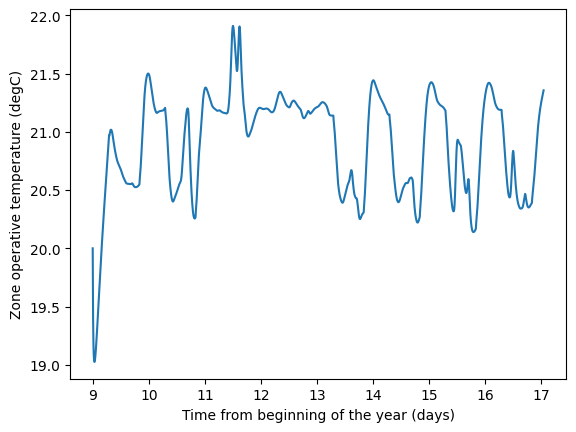

In [63]:
import numpy as np
import matplotlib.pyplot as plt

args = {'point_names':['reaTZon_y'],'start_time':-np.inf, 'final_time':np.inf}
res = requests.put('{0}/results'.format(url), data=args).json()['payload']
plt.plot(np.asarray(res['time'])/24/3600, np.asarray(res['reaTZon_y'])-273.15)
plt.xlabel('Time from beginning of the year (days)')
plt.ylabel('Zone operative temperature (degC)')
# plt.axvline(start_time_days, linestyle='--', color='r')

In [16]:
# Q: can we use native RestAPI float point instead of `-np.inf`
# ANS: Though unintuitive, it seems like we need to use np.inf

Note that most of the simulation results correspond to the one week warm-up period defined by the scenario initilization done before, and only a small part to the couple of control steps advanced during the scenario test period.  The start time of the test period, saved in the variable `start_time_days` earlier, is shown in red.

The results are provided during the warmup period so that for example, advanced controllers like MPC could use them for initial state estimation.

### Getting Core KPI Values

  

We're now ready to obtain the final KPIs, calculated based on the emulator performance during a simulation (starting from the initialization). The core KPIs, those that are calculated for every test case, are defined in BOPTEST to evaluate different aspects of a controller. These are:

  

* **Thermal discomfort**: reported with units of [$K \, h/zone$], defines the cumulative deviation of zone temperatures from upper and lower comfort limits that are predefined within the test case FMU for each zone, averaged over all zones. Air temperature is used for air-based systems and operative temperature is used for radiant systems.

* **Indoor Air Quality (IAQ) Discomfort**: reported with units of [$ppm \, h/zone$], defines the extent that the CO$_2$ concentration levels in zones exceed bounds of the acceptable concentration level, which are predefined within the test case FMU for each zone, averaged over all zones.

* **Energy Use**: reported with units of [$kWh/m^2$], defines the HVAC energy usage.

* **Peak electrical demand**:reported with units of [$kW/m^2$], defines the HVAC peak electrical demand.

* **Peak gas demand**:reported with units of [$kW/m^2$], defines the HVAC peak gas demand.

* **Peak district heating demand**:reported with units of [$kW/m^2$], defines the HVAC peak district heating demand.

* **Cost**: reported with units of [USD/$m^2$] or [EUR/$m^2$], defines the operational cost associated with the HVAC energy usage.

* **Emissions**: reported with units of [$kg \, CO_2/m^2$], defines the CO$_2$ emissions from the HVAC energy usage.


  
  

* **Computational time ratio**: defines the average ratio between the controller computation time and the test simulation control step. The controller computation time is measured as the time between two emulator advances.

  

The core KPIs are normally calculated at the end of the simulation to assess the controller performance, although they can be computed at any time. The warmup period is not taken into account for the calculation of the KPIs.

  

Get the core KPI values using the `GET /kpi` BOPTEST API endpoint.

In [41]:
requests.get('{0}/kpi'.format(url)).json()['payload']

{'cost_tot': 0.016234313085913422,
 'emis_tot': 0.01137696301027084,
 'ener_tot': 0.06812552700760979,
 'idis_tot': 0.0,
 'pdih_tot': None,
 'pele_tot': 0.015044889571272379,
 'pgas_tot': None,
 'tdis_tot': 0.0,
 'time_rat': 0.06118474694093068}

Q: what's the significance of warm-up period?
ANS: This type of initialization allows for a user to test their controller for arbitrary periods during the year. Note that the warm-up period is a period of simulation before the desired starting time that can be used to set initial conditions of the simulation at the start time. During warm-up, the baseline controller simulates the model to prepare it to a realistic operational state.

Q: What affect the caculation of KPIs?
ANS: The core KPIs are normally calculated at the end of the simulation to assess the controller performance, although they can be computed at any time. The warmup period is not taken into account for the calculation of the KPIs. Advance is another operation will affect KPIs.
(Try the following experiments)

In [66]:
y = requests.put('{0}/initialize'.format(url), 
                 data={'start_time':   75*24*3600,
                       'warmup_period': 7*24*3600}).json()
print(y['payload']['reaTZon_y']-273.15)
print(y['payload']['time']/24/3600)

requests.get('{0}/kpi'.format(url)).json()['payload']

21.907151167541087
75.0


{'cost_tot': 0.0,
 'emis_tot': 0.0,
 'ener_tot': 0.0,
 'idis_tot': 0.0,
 'pdih_tot': None,
 'pele_tot': 0.0,
 'pgas_tot': None,
 'tdis_tot': 0.0,
 'time_rat': nan}

In [67]:
y = requests.put('{0}/initialize'.format(url), 
                 data={'start_time':   31*24*3600,
                       'warmup_period': 7*24*3600}).json()
print(y['payload']['reaTZon_y']-273.15)
print(y['payload']['time']/24/3600)

requests.get('{0}/kpi'.format(url)).json()['payload']

21.364446797690675
31.0


{'cost_tot': 0.0,
 'emis_tot': 0.0,
 'ener_tot': 0.0,
 'idis_tot': 0.0,
 'pdih_tot': None,
 'pele_tot': 0.014981113580506486,
 'pgas_tot': None,
 'tdis_tot': 0.0,
 'time_rat': nan}

In [68]:
y = requests.put('{0}/initialize'.format(url), 
                 data={'start_time':   31*24*3600,
                       'warmup_period': 20*24*3600}).json()
print(y['payload']['reaTZon_y']-273.15)
print(y['payload']['time']/24/3600)

requests.get('{0}/kpi'.format(url)).json()['payload']

21.364512020821053
31.0


{'cost_tot': 0.0,
 'emis_tot': 0.0,
 'ener_tot': 0.0,
 'idis_tot': 0.0,
 'pdih_tot': None,
 'pele_tot': 0.01497515993626905,
 'pgas_tot': None,
 'tdis_tot': 0.0,
 'time_rat': nan}

Q: Can user configure control input during warm-up period?
ANS: No. Warm-up period only allows baseline control input. A user should use advance endpoint to input custom control.

Q: Is there a one-to-one mapping between the warm-up period and start-time in scenario and initialize? e.g., what's the warmup_period, and start_time for scenario: time_period':'peak_heat_day', 'electricity_price':'dynamic'? Is there an endpoint to retrieve such infomation?

Q: what will happen if the custom control input has longer duration than simulation step? e.g., when simulation step = 3600(sec), set oveHeaPumY_activate = 10 (h), i.e., y = requests.post('{0}/advance'.format(url), data={'oveHeaPumY_u':0.5, 'oveHeaPumY_activate': 10}).json()['payload']